In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the Excel file into a DataFrame
scotch_data = pd.read_excel('scotch.xlsx', header=[0,1], skipfooter=2)

# Keep the last 15 column names from the second level of the multi-index
last_15_columns = scotch_data.columns.get_level_values(1)[-15:]

# Combine the first two rows into a single header row separated by _
scotch_data.columns = ['_'.join(col) for col in scotch_data.columns]

# Reset the index after dropping rows
scotch_data = scotch_data.reset_index(drop=True)

# Rename the first two columns to 'name1' and 'name2'
scotch_data.rename(columns={scotch_data.columns[0]: 'name1', scotch_data.columns[1]: 'name2'}, inplace=True)

# Reassign the saved column names to the last 15 columns
scotch_data.columns = list(scotch_data.columns[:-15]) + list(last_15_columns)

# Display the dataframe
scotch_data


c:\Python311\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
c:\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,name1,name2,color_wyne,color_yellow,color_v.pale,color_pale,color_p.gold,color_gold,color_o.gold,color_f.gold,...,DISTRICT,islay,midland,spey,east,west,north,lowland,campbell,islands
0,Aberfeldy,Aberfeldy,0,1,0,0,0,0,0,0,...,MIDLAND,0,1,0,0,0,0,0,0,0
1,Aberlour,Aberlour,0,0,0,0,0,0,0,0,...,SPEY,0,0,1,0,0,0,0,0,0
2,Ardberg,Ardberg,0,0,0,0,0,0,0,0,...,SOUTH,1,0,0,0,0,0,0,0,0
3,Ardmore,Ardmore,0,0,0,0,1,0,0,0,...,SPEY,0,0,1,0,0,0,0,0,0
4,Auchentoshan,Auchentosh,0,0,0,0,1,0,0,0,...,WEST,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,Tobermory,Tobermory,0,0,0,0,0,0,0,1,...,MULL,0,0,0,0,0,0,0,0,1
105,Tomatin,Tomatin,0,0,0,0,0,0,0,1,...,SPEY,0,0,1,0,0,0,0,0,0
106,Tomintoul,Tomintoul,0,0,0,0,0,0,0,1,...,SPEY,0,0,1,0,0,0,0,0,0
107,Tormore,Tormore,0,0,0,0,0,0,0,1,...,SPEY,0,0,1,0,0,0,0,0,0


# Explanatory Data Analysis
1. The dataset contains different characteristics for 109 different whiskies.

2. Binary Columns:

   - The dataset contains 68 binary columns representing different characteristics of the whisky, sub-divided into colour, palate, nosem body and finish.
   - These binary columns encode whether a particular characteristic is present or absent.
   - Since these are binary, they will make a good indication later for similarities between whiskies in the dataset (where 1 indicates a similarity).

3. Numeric Columns:

   - 'AGE': Age of the whisky in ints, presumably since a specific year.
   - 'DIST': A score from 1-5 atesting to the quality of the distillery (5 is best).
   - 'SCORE': A score of the whisky quality.
   - '%': probably refers to alcohol percentage by volume.

4. Categorical Columns:
   - Columns describing the origin of grains and distillery provide categorical information about the whisky's production process and source. These columns are broken down to binary variables in 9 additional columns.

<ul>
    <li>I will first want to see whether the 2 name columns are actually needed and if I can delete the 2nd column/combine the columns.</li>
    <li>I will summarize the whiskies by origin and show the distribution of distilleries per region.</li>
</ul>

In [3]:
# Find the indices where the values in the first two columns are in some way different
different_indices = scotch_data[scotch_data.columns[0]] != scotch_data[scotch_data.columns[1]]

# Extract the rows for these indecies
different_values = scotch_data[different_indices].iloc[:,:2]

print(different_values)

# Filter different_values to keep rows where the string from the second column is not already contained within the first column
filtered_values = different_values[different_values.apply(lambda row: row.iloc[1] not in row.iloc[0], axis=1)]

print(f'There are {len(filtered_values)} meaningful differences between name1 and name2 columns')

                  name1       name2
4          Auchentoshan  Auchentosh
15          Blair Athol  Blair Atho
18        Bruichladdich  Bruichladd
19         Bunnahabhain  Bunnahabha
21          Caperdonich  Caperdonic
26          Cragganmore  Cragganmor
27        Craigellachie  Craigellac
35          Fettercairn  Fettercair
36          Glen  Albyn  Glen  Alby
37         Glenallachie  Glenallach
40         Glen Deveron  Glen Dever
41          Glendronach  Glendronac
45          Glenfarclas  Glenfarcla
46          Glenfiddich  Glenfiddic
47         Glen Garioch  Glen Gario
48        Glenglassaugh  Glenglassa
52          Glenkinchie  Glenkinchi
57         Glenmorangie  Glenmorang
61          Glen Scotia  Glen Scoti
63         Glentauchers  Glentauche
66        Glenury Royal  Glenury Ro
67        Highland Park  Highland P
93      Saint Magdalene  Saint Magd
98   Springbank-Longrow     Longrow
108        Tullibardine  Tullibardi
There are 0 meaningful differences between name1 and name2 colum

In [4]:
# Drop the second column
scotch_data = scotch_data.drop(scotch_data.columns[1], axis=1)

In [5]:
# Arrange the DataFrame by the 'DISTRICT' column in descending order
scotch_data_sorted_desc = scotch_data.sort_values(by='DISTRICT', ascending=False)

# Display the sorted DataFrame
print(scotch_data_sorted_desc)

                 name1  color_wyne  color_yellow  color_v.pale  color_pale  \
54           Glenlochy           0             0             0           0   
4         Auchentoshan           0             0             0           0   
76            Ladyburn           1             0             0           0   
49           Glengoyne           0             0             0           0   
89                Oban           0             0             0           0   
..                 ...         ...           ...           ...         ...   
92            Rosebank           0             0             0           0   
98  Springbank-Longrow           0             0             0           0   
61         Glen Scotia           0             0             0           0   
97          Springbank           0             0             0           0   
14            Bladnoch           0             1             0           0   

    color_p.gold  color_gold  color_o.gold  color_f.gold  color

islay        7
midland      6
spey        57
east        10
west         5
north        7
lowland      9
campbell     3
islands      5
dtype: int64


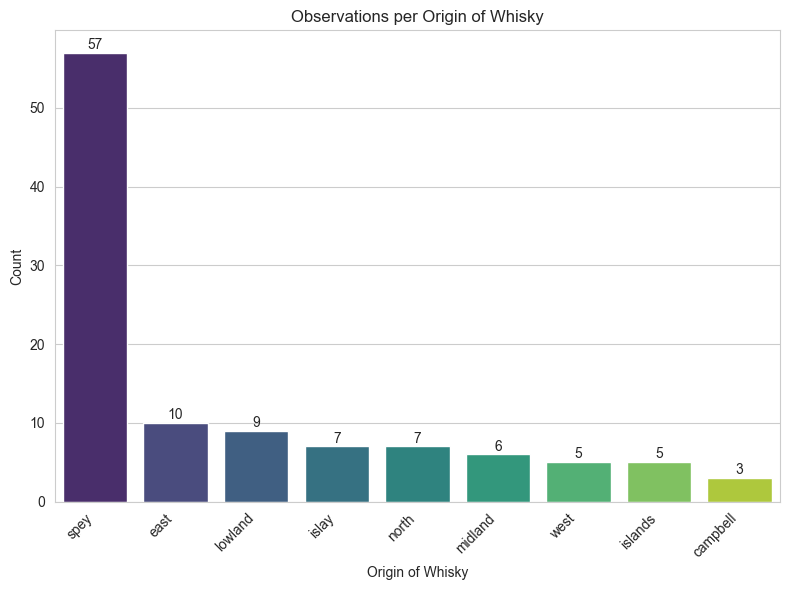

In [6]:
# Remove trailing spaces from column names
scotch_data.columns = scotch_data.columns.str.strip()

# Define the dummy variable columns representing the origin of whisky
origin_columns = ['islay', 'midland', 'spey', 'east', 'west', 'north', 'lowland', 'campbell', 'islands']

# Sum the dummy variable columns to get the count of observations for each origin
origin_counts = scotch_data[origin_columns].sum()

print(origin_counts)

# Sort the counts in descending order
origin_counts_sorted = origin_counts.sort_values(ascending=False)

# Set the Seaborn style to 'whitegrid'
sns.set_style('whitegrid')

# Plot the counts using a countplot with a sequential color palette
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=origin_counts_sorted.index, y=origin_counts_sorted.values, palette='viridis')  # Use a sequential color palette (viridis)
plt.xlabel('Origin of Whisky')
plt.ylabel('Count')
plt.title('Observations per Origin of Whisky')
plt.xticks(rotation=45, ha='right')

# Add count labels on top of each bar
for i, count in enumerate(origin_counts_sorted):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

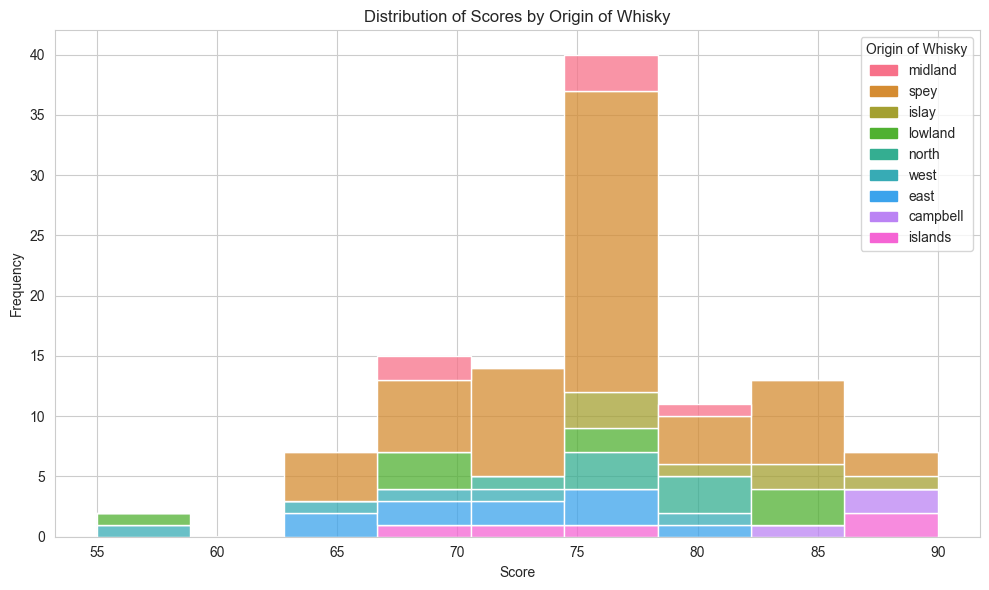

In [7]:
# Define the origin columns
origin_columns = ['islay', 'midland', 'spey', 'east', 'west', 'north', 'lowland', 'campbell', 'islands']

# Extract the 'SCORE' column
score_column = scotch_data['SCORE']

# Create a new DataFrame with 'SCORE' and 'origin' columns
score_and_origin = pd.DataFrame({'SCORE': score_column})

# Add the 'origin' column
score_and_origin['origin'] = scotch_data[origin_columns].idxmax(axis=1).apply(lambda x: x.split('_')[0])

# Create a dictionary mapping each origin to a distinct color
origin_colors = {origin: sns.color_palette('husl', len(score_and_origin['origin'].unique()))[i] for i, origin in enumerate(score_and_origin['origin'].unique())}

# Create a stacked histogram of SCORE based on the origin of whisky with 9 bins and explicit colors
plt.figure(figsize=(10, 6))
sns.histplot(data=score_and_origin, x='SCORE', hue='origin', multiple='stack', palette=origin_colors, bins=9)
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores by Origin of Whisky')

# Get unique values in the 'origin' column
unique_origins = score_and_origin['origin'].unique()

# Create the legend explicitly with unique origin values and specified colors
legend_handles = [plt.Rectangle((0,0),1,1, color=origin_colors[origin]) for origin in unique_origins]
plt.legend(legend_handles, unique_origins, title='Origin of Whisky')

plt.tight_layout()
plt.show()

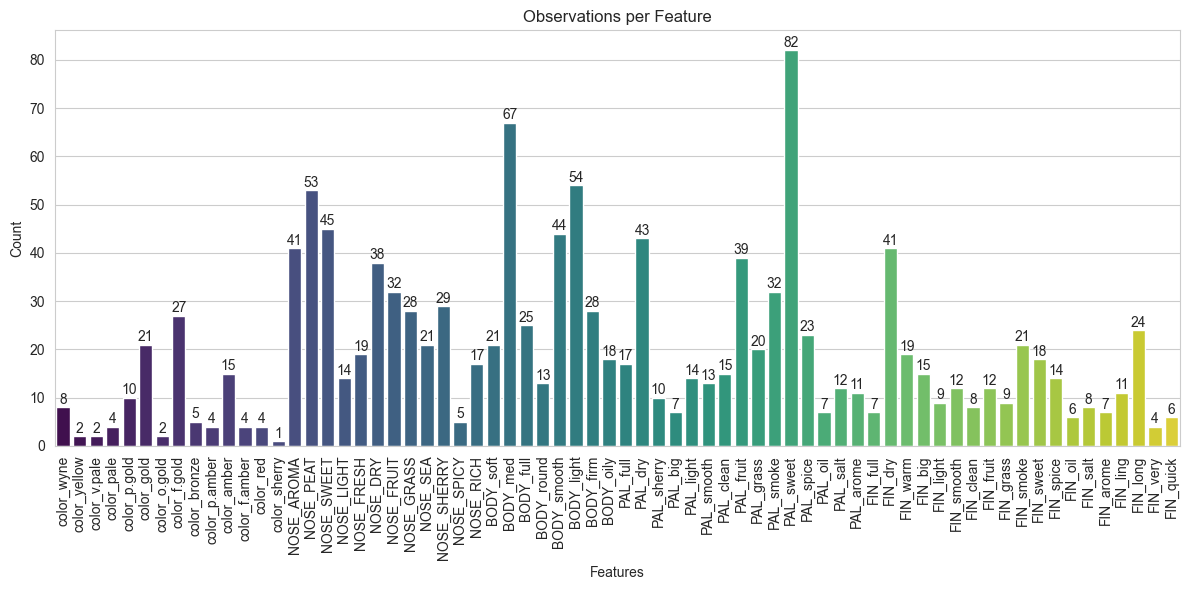

In [8]:
# Step 1: Identify categorical variables and origin variables
categorical_variables = ['REGION', 'DISTRICT']
origin_variables = ['islay', 'midland', 'spey', 'east', 'west', 'north', 'lowland', 'campbell', 'islands']
numeric_variables = ['AGE', 'DIST', 'SCORE', '%']

# Step 2: Create a DataFrame of features excluding categorical and origin variables
features = scotch_data.drop(['name1'] + categorical_variables + origin_variables + numeric_variables, axis=1)

# Count observations for each feature
feature_counts = features.sum()

# Plot the counts of observations for features
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=feature_counts.index, y=feature_counts.values, palette='viridis')  # Use a sequential color palette (viridis)
plt.xlabel('Features')
plt.ylabel('Count')
plt.title('Observations per Feature')
plt.xticks(rotation=90)

# Add count labels on top of each bar
for i, count in enumerate(feature_counts):
    ax.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Conclusions:
<ol>
    <li>All names from the 2nd column are contained in the first, the column can be dropped.</li>
    <li>We can easily see a disproportionate representation of Speyside as the location of distilleries in the set with 57 counts.</li>
    <li>There are dummy features that appear so commonly that they might prove redundant in a subsequent model, e.g. PAL_sweet and BODY_med, shared between 82 and 67 whiskies respectively</li>
    <li>A visual inspection of the score by origin reveals the following trends:
        <ul>
            <li>Campbell distillery whiskies score on the high end of the chart.</li>
            <li>Islay spreads between mid to high score.</li>
            <li>West spreads between low to mid scores.</li>
            <li>Midland, Lowland and Islands spread pretty evenly throughout.</li>
            <li>Speyside is over represented, but most of its mass is at the mid score.</li>
            <li>The North is mostly in the middle of the score chart.</li>
        </ul>
    </li>
</ol>

Since I know very little about whisky, I will choose the whisky with the highest score that has a light, smooth body and a sweet finish.
In calculating the similarities, however, I will leave in more characteristics to imitate a real-life scenario where I choose my whisky by flavour.

To avoid disproportionately calculating by the integer columns I will first preprocess them with MinMaxScaler to normalize them between 0 and 1.

In [9]:
# Define criteria for selecting a whisky
criteria = {
    'BODY_smooth': 1,  # Smooth palate
    'BODY_light': 1,   # Light body
    'FIN_sweet': 1    # Sweet finish
}

# Filter the scotch_data DataFrame based on the criteria
selected_whisky = scotch_data[(scotch_data['BODY_smooth'] == criteria['BODY_smooth']) & 
                              (scotch_data['BODY_light'] == criteria['BODY_light']) &
                              (scotch_data['FIN_sweet'] == criteria['FIN_sweet'])]

# Find the whisky with the highest score among the filtered whiskies
selected_whisky = selected_whisky.loc[selected_whisky['SCORE'].idxmax()]

print(f"Based on my selected criteria, my whisky of choice is {selected_whisky['name1']} with a score of {selected_whisky['SCORE']}.")

Based on my selected criteria, my whisky of choice is Springbank with a score of 88.


In [10]:
pd.options.mode.chained_assignment = None

# Select all columns except 'name1', 'REGION', 'DISTRICT'
selected_columns = [col for col in scotch_data.columns if col not in ['name1', 'REGION', 'DISTRICT','islay', 'midland',	'spey',	'east',	'west',	'north', 'lowland',	'campbell',	'islands']]

# Extract selected features and normalize specific columns
selected_features = scotch_data[selected_columns]
columns_to_normalize = ['AGE', 'DIST', 'SCORE', '%']

# Normalize specific columns between 0 and 1
scaler = MinMaxScaler()
selected_features[columns_to_normalize] = scaler.fit_transform(selected_features[columns_to_normalize])

# Compute cosine similarity between the selected whisky and all other whiskies
selected_index = scotch_data[scotch_data['name1'] == selected_whisky['name1']].index[0]
selected_features_normalized = selected_features.values[selected_index].reshape(1, -1)
similarity_scores = cosine_similarity(selected_features_normalized, selected_features)

# Sort the similarity scores and get the top 5 indices
sorted_indices = np.argsort(similarity_scores)[0][::-1][1:6]  # Exclude the selected whisky itself

# Extract top 5 similar whiskies
top_5_similar_whiskies = scotch_data.iloc[sorted_indices]

# Display the top 5 similar whiskies and their similarity scores
print("Top 5 Similar Whiskies:")
for i, index in enumerate(sorted_indices):
    whisky = scotch_data.loc[index]
    print(f"{whisky['name1']}: Similarity Score = {similarity_scores[0][index]}")

Top 5 Similar Whiskies:
Inchgower: Similarity Score = 0.6383208597759078
Glen Deveron: Similarity Score = 0.597361720544205
Glen Scotia: Similarity Score = 0.5731115131926885
Oban: Similarity Score = 0.5229466115313555
Bunnahabhain: Similarity Score = 0.518584418270752


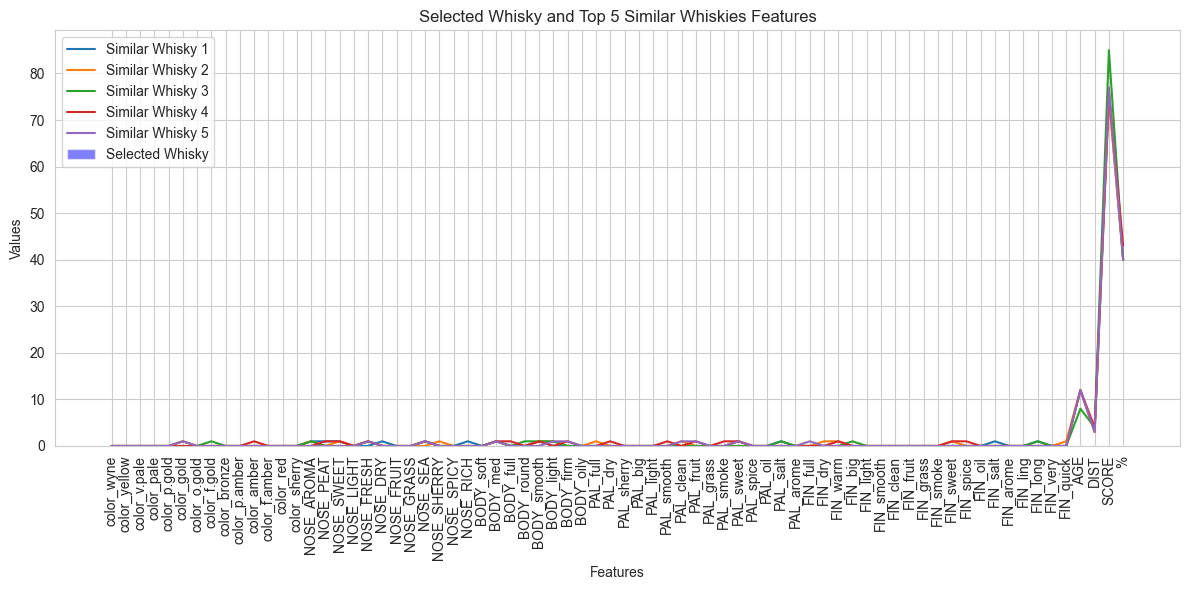

In [11]:
# Get the features of the selected whisky
selected_whisky_features = selected_whisky[selected_columns]

# Get the features of the top 5 similar whiskies
top_5_similar_whiskies_features = top_5_similar_whiskies[selected_columns]

# Plot the features of the selected whisky and the top similar whiskies
plt.figure(figsize=(12, 6))

# Plot features of the selected whisky
plt.bar(selected_whisky_features.index, selected_whisky_features.values[0], color='blue', alpha=0.5, label='Selected Whisky')

# Plot features of the top 5 similar whiskies
for i in range(len(top_5_similar_whiskies)):
    plt.plot(top_5_similar_whiskies_features.columns, top_5_similar_whiskies_features.values[i], label=f"Similar Whisky {i+1}")

plt.xticks(rotation=90)
plt.title('Selected Whisky and Top 5 Similar Whiskies Features')
plt.xlabel('Features')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()
plt.show()


### Key Takeaways:
- We can see there are similarities between the selected whiskies.
- The strongest similarities still seem to be in the numeric columns, even after normalization.
- To address this, I will try to find similar whiskies using a dendogram instead.

In [12]:
# Step 1: Identify categorical variables and origin variables
categorical_variables = ['REGION', 'DISTRICT']
origin_variables = ['islay', 'midland', 'spey', 'east', 'west', 'north', 'lowland', 'campbell', 'islands']

# Step 2: Create a DataFrame of features excluding categorical and origin variables
features = scotch_data.drop(['name1'] + categorical_variables + origin_variables, axis=1)

# Step 3: Extract the 'name1' column
labels = scotch_data['name1']


# Extract selected features and normalize specific columns
columns_to_normalize = ['AGE', 'DIST', 'SCORE', '%']

# Normalize specific columns between 0 and 1
scaler = MinMaxScaler()
features[columns_to_normalize] = scaler.fit_transform(features[columns_to_normalize])

# Calculate the linkage: mergings
mergings = linkage(features, method='complete')

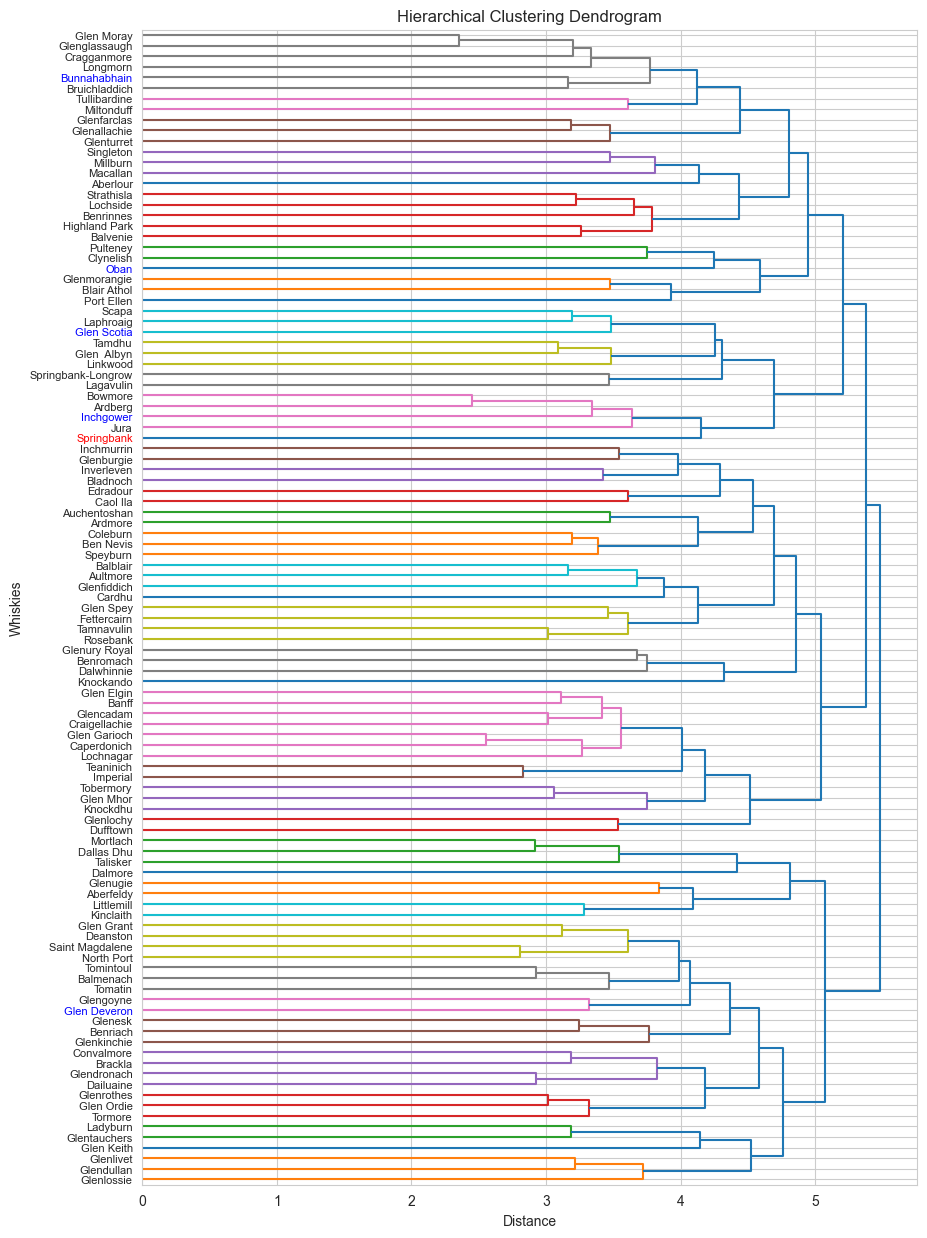

In [13]:
# Define custom colors for the labels of top 5 similar whiskies and selected whisky
color_dict = {}
for whisky in top_5_similar_whiskies['name1'].values:
    color_dict[whisky] = 'blue'
color_dict[selected_whisky['name1']] = 'red'

plt.figure(figsize=(10, 15))  
dendrogram(mergings,
           labels=labels.values,  
           orientation='right',    
           leaf_rotation=0,       
           leaf_font_size=8,     
           
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Whiskies')

# Get the current tick labels
tick_labels = plt.gca().get_ymajorticklabels()

# Color the labels according to color_dict
for label in tick_labels:
    whisky_name = label.get_text()
    if whisky_name in color_dict:
        label.set_color(color_dict[whisky_name])

plt.show()

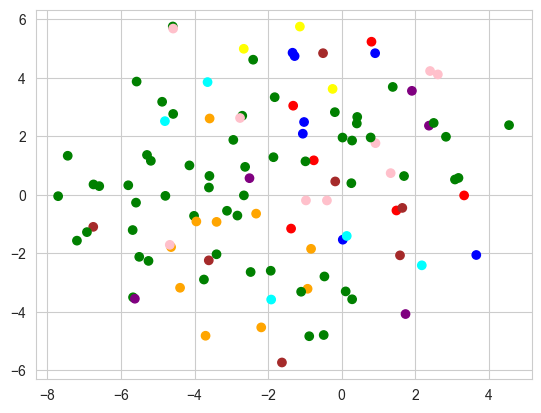

In [14]:
origin = scotch_data[origin_columns].idxmax(axis=1).apply(lambda x: x.split('_')[0])

# Define a color map for each origin category
color_map = {
    'islay': 'blue',
    'midland': 'red',
    'spey': 'green',
    'east': 'orange',
    'west': 'purple',
    'north': 'brown',
    'lowland': 'pink',
    'campbell': 'yellow',
    'islands': 'cyan'
}

# Map each origin category to its corresponding color
colors = origin.map(color_map)

# Create a TSNE instance: model
model = TSNE(learning_rate=200)
# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(features)
# Select the 0th feature: xs
xs = tsne_features[:,0]
# Select the 1st feature: ys
ys = tsne_features[:,1]
# Scatter plot, coloring by variety_numbers
plt.scatter(xs, ys, c=colors)
plt.show()

Clustering with KNN

In [15]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'origin' variable
origin_encoded = label_encoder.fit_transform(origin)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, origin_encoded, test_size=0.3, random_state=21, stratify=origin_encoded)

# Create knn model
knn = KNeighborsClassifier(n_neighbors=14)
# Instantiate the model
knn.fit(X_train, y_train)

# Calculate and print R-squared
print(knn.score(X_test, y_test))

# Make predictions on the test set
y_pred = knn.predict(X_test)

# Print the classification report
print(f' Classification report:\n{classification_report(y_test, y_pred, zero_division=True)}')


  
  


0.5757575757575758
 Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         1
           1       1.00      0.33      0.50         3
           2       1.00      0.00      0.00         1
           3       1.00      0.50      0.67         2
           4       1.00      0.00      0.00         3
           5       1.00      0.00      0.00         2
           6       1.00      0.00      0.00         2
           7       0.55      1.00      0.71        17
           8       1.00      0.00      0.00         2

    accuracy                           0.58        33
   macro avg       0.95      0.20      0.21        33
weighted avg       0.77      0.58      0.45        33



### Summary
I have tried approaching the porblem in 4 ways:
1. Similarities: I first conducted a similarity analysis. To do so, I've rescaled my numerical features (min-max normalization), to cast them between 0 and 1. 
Then I calculated the similarities for all whiskies in the dataset to my selected whisky and reduced the selection to the top 5. The top 5 choices all showed similar scores between 75-88, aged between 12-15 with the exception of Glen Scotia aged 8, DIST 3-5 and shared features like PAL_sweet (except Glen Scotia), NOSE_FRESH (except Inchgower), NOSE_SEA (except Glen Scotia), BODY_smooth (except Bunnahabhain).
2. Next I've performed hierarchicak clustering dendugram to visualize the relationships between whiskies based on their features. This yielded a group for my selected whisky that did not match the similarities analysis, most likely due to not exclusing 0 values for the selected whisky from the subsequent analysis.
3. t-SNE Visualization:
t-SNE dimensionality reduction was applied to visualize the data in a lower-dimensional space while preserving local structure.
The t-SNE plot was colored based on the origin of whiskies to observe any clustering patterns. No strong patterns appear based on origin.
4. Lastly I attempted to classify the data using a KNN and the origins of each whisky. This achieved the following results:
    * The precision for most classes is 1.00 except class 7 with 0.55, indicating that the classifier performs well in correctly identifying instances of those classes.

    * The recall varies across classes, with some classes having a recall of 1.00, indicating that the classifier correctly identifies all instances of those classes. However, for classes 0, 2, 4, 5, and 6, the recall is 0.00, indicating that the classifier fails to identify any instances of these classes.

    * F1-score: The F1-score, which is the harmonic mean of precision and recall, is relatively low for most classes, especially for classes 0, 2, 4, 5, and 6, where precision and recall are both low. Since the classes are disproportionate, this has a smaller effect on the overall performance of the model, which is dectated mostly by class 7 (and to some extent 1 and 4).
    
    * The overall accuracy of the classifier is 0.58, indicating that 58% of the instances were correctly classified across all classes.

    * The macro average precision, recall, and F1-score are relatively low, indicating that the classifier's performance varies across different classes and is not consistent.

    * The weighted average precision, recall, and F1-score are slightly higher than the macro average. This is again due to the disproportion in the dataset and the ability of the model to predict class 7 correctly with recall=1 and accuracy of 55%.
